# Cats and Dogs
by uramoon@kw.ac.kr<br><br>
고양이와 개를 분류하는 간단한(?) 모델을 만들어봅시다!<br>
런타임 유형은 가급적 GPU로 설정하세요. <br><br>

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/15<br>
**Last modified:** 2020/05/12<br>
**Description:** Complete guide to transfer learning & fine-tuning in Keras.<br>
(<a href="https://raw.githubusercontent.com/ronreiter/interactive-tutorials/master/LICENSE">Apache 2.0 License</a>)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 데이터 가져오기
원래 25,000장의 그림이 있는데 15,000장만 가져와서 그 중 10,000장은 훈련, 2500장은 검증, 2500장은 테스트에 사용하겠습니다.<br>
(오염된 이미지들이 있어서 다 받아오진 못하고 수 백장의 사진이 걸러집니다.)

In [2]:
# 이해하지 않아도 괜찮습니다.

# 텐서플로우에서 제공하는 데이터셋 가져오기
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# setattr(object, name, value) : object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여한다.
# 임시 코드 (다운로드가 안되면 지우세요.)
# setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")


# tensorflow 에서 제공하는 "cats_vs_dogs" dataset을 가져온다.
# 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs", # 개와 고양이 데이터셋
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


## TODO0: 데이터셋 살펴보기<br>


<class 'tuple'> 2
(262, 350, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> () 1


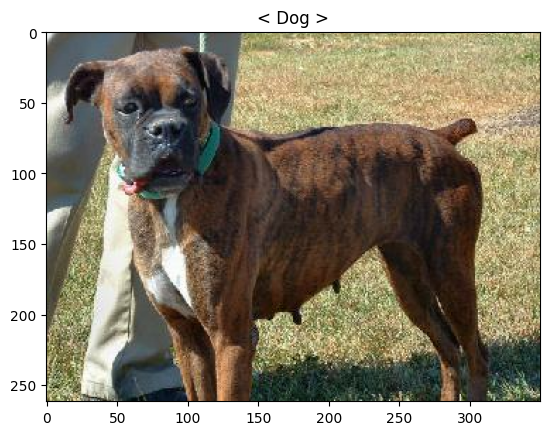

In [3]:
import matplotlib.pyplot as plt

# 훈련 데이터셋에서 하나의 데이터만 가져오기
# take는 튜플(순서쌍)을 반환하므로 ,로 첫 번째 원소만 가져옵니다.
data, = train_ds.take(1)  # 마지막에 콤마(,)가 없다면 data를 가져올 때 for문을 써야한다.

print(type(data), len(data))

# 데이터 안에는 이미지(그림)와 레이블(정답)이 기재되어 있습니다.
image = data[0] #TODO: data의 첫 번째 원소
label = data[1] #TODO: data의 두 번째 원소

# TODO: 이미지 모양 (shape) 출력해보기, 가장 마지막에 기재된 채널 수를 확인해보세요.
print(image.shape)

# TODO: 코드 한 줄로 image 그려보기 
plt.imshow(image)

# TODO: 그림 위에 title 달기 / label이 0이면 Cat, 1이면 Dog
idx2label = {0: 'Cat', 1: 'Dog'}
print(type(label), label.shape, label.numpy())
# plt.title(label)
plt.title(f"< {idx2label[label.numpy()]} >")

plt.show()

## TODO1: 훈련 데이터 그려보기
훈련 데이터의 첫 9장을 그려봅시다.


* 이미지의 크기가 전부 다른 것을 확인할 수 있다.
* Color 이미지 이다.

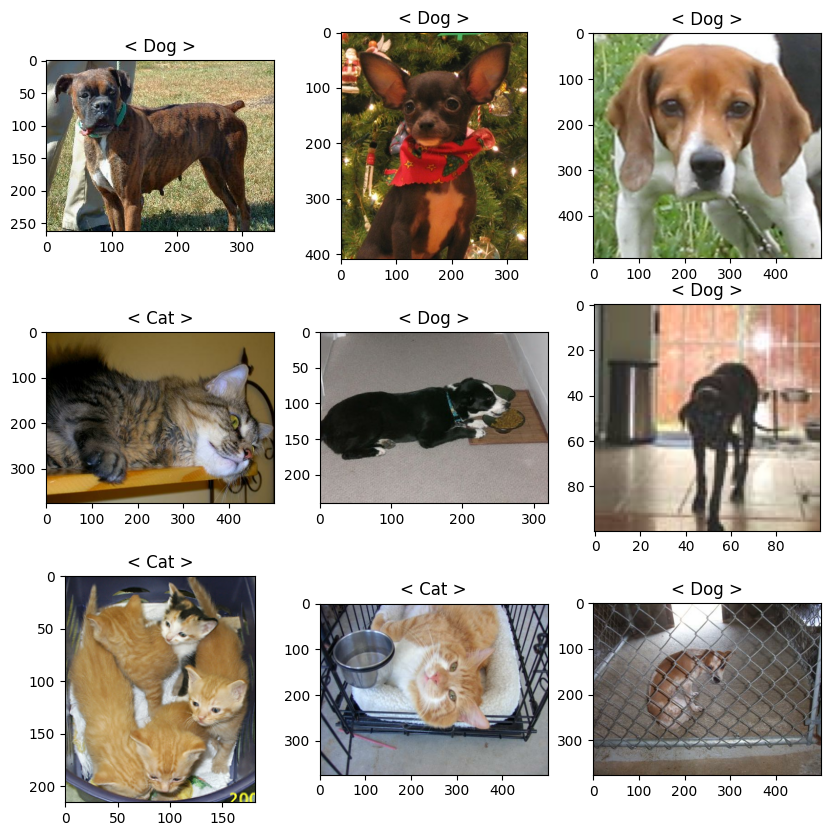

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)): # TODO: take 함수로 9장 가져오세요.
    ax = plt.subplot(3, 3, i+1) # 행 3개, 열 3개, 1로 시작하는 인덱스

    # TODO: image를 그리세요.
    plt.imshow(image)
    
    # TODO: Cat인지 Dog인지 타이틀로 표시하세요.
    plt.title(f"< {idx2label[label.numpy()]} >")
plt.show()

## TODO2: 데이터셋 전처리하기
나중에 우리는 150 x 150 크기의 그림을 입력으로 받는 Xception 모델을 사용할 것이기 때문에<br> 그림 크기를 150 x 150으로 변환하고 Xception의 전처리 기법을 사용하겠습니다.<br>
(Xception: Keras 개발자가 Google에서 만든 합성곱 인공신경망)

In [5]:
size = (150, 150)

# train_ds의 모든 원소에 대해 람다라는 이름 없는 함수를 적용합니다.
# 각 원소는 이미지 (X)와 레이블 (y)을 순서쌍의 형태로 갖고 있는데 
# X에는 resize 함수로 이미지 크기를 변경해 반환하고 y는 그대로 반환합니다.
# 원래 이미지는 [0, 255]에 해당하는 int였는데, resize 함수는 [0, 255] float으로 타입을 바꿔줍니다.
train_ds = train_ds.map(lambda X, y: (tf.image.resize(X, size), y)) # 튜플 형태로 반환해야 한다. (data, label)
validation_ds = validation_ds.map(lambda X, y: (tf.image.resize(X, size), y)) #TODO: 검증 데이터셋 변환
test_ds = test_ds.map(lambda X, y: (tf.image.resize(X, size), y)) #TODO: 테스트 데이터셋 변환

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

# preprocessing 이전
for i, (image, label) in enumerate(train_ds.take(1)):
    print(image.shape, image[130][130], image[80][36], image[47][90])


# 람다 함수를 사용해 각 데이터셋의 X (이미지)에만 preprocess_input을 적용해보세요.
# [0, 255] float이 [-1, 1] float으로 바뀝니다.
# Hint: 반환할 때 바로 위의 코드 블록과 동일하게 순서쌍의 형태 (이미지, 레이블)로 반환해야 합니다.
# 튜플 형태로 반환해야 한다. (data, label)
train_ds = train_ds.map(lambda X, y: (preprocess_input(X), y)) #TODO
validation_ds = validation_ds.map(lambda X, y: (preprocess_input(X), y)) #TODO
test_ds = test_ds.map(lambda X, y: (preprocess_input(X), y)) #TODO

# preprocessing 이후
for i, (image, label) in enumerate(train_ds.take(1)):
    print(image.shape, image[130][130], image[80][36], image[47][90])

type(train_ds.take(1)), type(train_ds)

(150, 150, 3) tf.Tensor([60.320007 44.320007 31.320007], shape=(3,), dtype=float32) tf.Tensor([183.5154  181.03983 167.63536], shape=(3,), dtype=float32) tf.Tensor([121.57789  86.68903  69.33353], shape=(3,), dtype=float32)
(150, 150, 3) tf.Tensor([-0.5269019  -0.6523921  -0.75435287], shape=(3,), dtype=float32) tf.Tensor([0.43933642 0.4199202  0.31478715], shape=(3,), dtype=float32) tf.Tensor([-0.04644793 -0.320086   -0.45620763], shape=(3,), dtype=float32)


(tensorflow.python.data.ops.take_op._TakeDataset,
 tensorflow.python.data.ops.map_op._MapDataset)

In [7]:
# 빠른 속도를 위해 데이터셋을 32장씩 묶어 준비합니다.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

2 (32, 150, 150, 3) tf.Tensor([1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1], shape=(32,), dtype=int64)


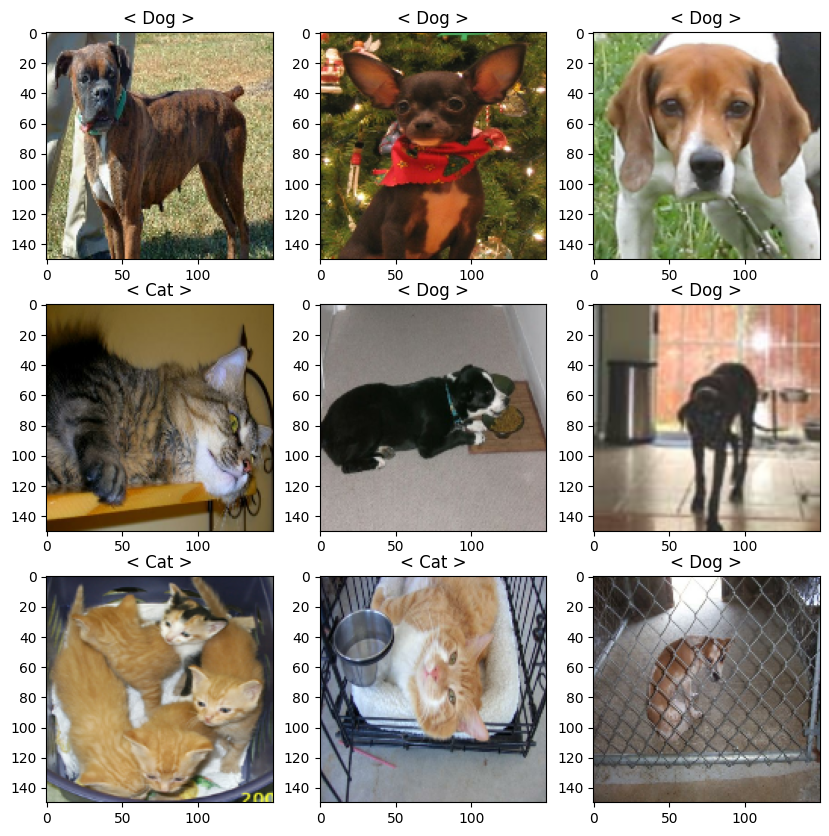

In [8]:
# 훈련 데이터 첫 9장을 그려보세요.

plt.figure(figsize=(10, 10))
batch, = train_ds.take(1) # 이제부터 1의 의미는 한 묶음 (32장) 가져오기


print(len(batch), batch[0].shape, batch[1])
images, labels = batch[0], batch[1] #TODO: 한 줄로 할당해보세요. 두 줄로 하셔도 됩니다.

# TODO1의 리사이징 버전이 그려져야 합니다.
for i, image in enumerate(images[:9]): #TODO: images 첫 9장 슬라이싱하세요.
  plt.subplot(3, 3, i + 1)
  # matplotlib은 [0, 255] int나 [0, 1] float을 제대로 그리기 때문에 
  # 우리의 입력인 [-1, 1] float은 이상하게 그려집니다.
  # 그냥 그려봐도 되고 image에 1을 먼저 더한 후 2로 나누어서 [0, 1] float으로 그려도 됩니다. 
  # (NumPy에서는 다차원 배열의 각 원소에도 손쉽게 덧셈, 나눗셈이 가능합니다.)
  # TODO: image 그리기
  image += 1
  image /= 2.0
  plt.imshow(image)
  
  # TODO: Cat/Dog title 설정하기 
  plt.title(f"< {idx2label[labels[i].numpy()]} >")
    
plt.show()

## TODO3: 데이터 늘리기<br>
별도의 데이터 증강 없이 딥러닝 모델에 데이터를 변환하는 층을 포함시킬 것입니다.<br>
(훈련할 때 인공신경망은 항상 원본에서 변형된 그림으로 학습합니다.)
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation



* 특수한 pixel 값보다 다양한 패턴을 찾게 된다.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# 좌우로만 뒤집는 층과 360도의 10%만큼 시계, 반시계로 회전하는 층을 만들어보세요.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), #TODO: 각 괄호 안에 적절한 값을 넣으셔야 합니다.
        layers.RandomRotation(0.1), #TODO: 이 층 뒤에 계속 다른 층이 연결될 예정이라 Comma를 지우시면 안됩니다. 
    ] 
)

Label :  Cat
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)
(150, 150, 3)
(1, 150, 150, 3)


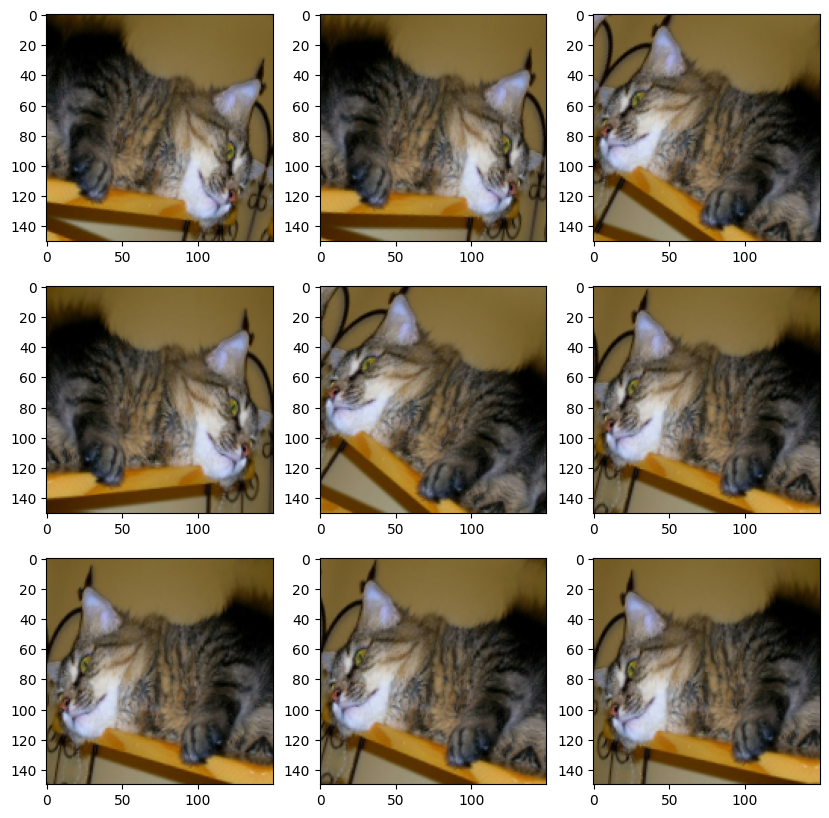

In [10]:
# 텐서에 reshape 적용 가능하게 만드는 코드
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# TODO: 전처리된 훈련 데이터셋(train_ds)에서 네 번째 그림 (고양이)를 가져오세요.
image = images[3]  # images에서 가져오시면 쉽습니다.
print("Label : ", idx2label[int(labels[3])])



# 현재 image 에서는 [-1, 1] float 이 저장되어 있다.
# matplotlib은 [0, 255] int나 [0, 1] float을 제대로 그리기 때문에
# image에 1을 먼저 더한 후 2로 나누어서 [0, 1] float으로 그려보자.
image += 1
image /= 2.0



# TODO: 훈련 데이터의 첫 번째 그림을 데이터 증강층으로 변형하여 9장 그려보세요.
# 의도한 훈련 데이터가 생성되는지 확인하고 그렇지 않다면 데이터 증강층을 다시 만드세요.
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i + 1)

  print(image.shape)
  print(image.reshape(1, image.shape[0], image.shape[1], image.shape[2]).shape)

  # 딥러닝 층으로 들어갈 때에는 (그림 인덱스, 세로, 가로, 채널)로 들어가야 합니다.
  # 현재 image는 (세로, 가로, 채널)입니다. 차원 늘리기 필요.  
  # pic에 image의 변형된 그림이 저장됩니다.
  pic = data_augmentation(image, training=True) #TODO: image의 차원을 늘려서 입력하세요. 차원 늘리는 함수 혹은 reshape도 가능
  
  # Q: training 옵션은 현재 훈련 중인지 아닌지를 알려주는데 증강층은 훈련할 때에만 동작합니다.
  # 즉 실전에 투입되어 모르는 그림을 인식할 때에는 동작하지 않습니다. 왜 그럴까요? (중요)
  # A:

  # 변형된 그림을 그리기 위해 의미 없이 늘린 차원 다시 줄이기 
  pic = pic.reshape(image.shape) #TODO
  # TODO: pic을 그려보세요.
  plt.imshow(pic)
  
plt.show()

## TODO4: 모델 정의하기<br>
클래스가 0 (고양이)와 1 (개) 밖에 없으므로 loss는 binary_crossentropy를 사용합니다.<br>
입력은 (150, 150, 3), 마지막 출력층은 노드가 하나입니다. (0이면 고양이, 1이면 개)<br>
출력은 하나의 노드에서 0 또는 1이므로 출력층의 활성화 함수는 softmax 대신 sigmoid 등을 사용해야 합니다.<br>
softmax는 여러 개 중에서 무엇을 선택할까인데 여기에 사용하면 무조건 하나의 출력 노드를 1로 만듭니다.<br>
sigmoid (S자형 곡선)의 경우에는 0과 1사이의 값을 출력합니다. (Cats vs. Dogs)<br>
그 외에는 자유롭게 만드세요. (Conv2D 층은 꼭 사용하시기 바랍니다.)

In [11]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

model = models.Sequential()

# TODO: 입력층
model.add(layers.Input(shape=(150, 150, 3)))

# 데이터 증강층
model.add(data_augmentation) #TODO: 위에서 만든 데이터 증강층을 넣으세요.

# filters : Integer, the dimensionality of the output space
model.add(layers.Conv2D(filters=32, kernel_size = (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))    
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.1))

# 자유롭게 설정

# 출력층
model.add(layers.Dense(1, activation='sigmoid')) # TODO: 노드 수와 활성화 함수 기재 (softmax 사용 금지)
    
# 컴파일
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [12]:
# 훈련해야 하는 파라미터가 몇 개인지 확인해보세요.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (150, 150, 3)             0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)       

## TODO5: 모델 훈련

In [13]:
# validation_ds도 제공하여 테스트 데이터에 대한 성능도 가늠해보세요. 
# (validation_split 대신 validation_data= 사용)
# 데이터셋 사용시에는 X(그림)와 y(정답)을 따로 넣을 필요 없이 train_ds만 입력하면 됩니다.
# 여기에서 너무 많은 시간을 사용하지 마세요. (정확도 70% 이상, 30분 이내 완료 추천)

from keras.callbacks import EarlyStopping

epochs = 10000
es = EarlyStopping(patience=15, restore_best_weights=True) #TODO
model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=es) #TODO

Epoch 1/10000
291/291 [==============================] - 37s 78ms/step - loss: 0.8860 - accuracy: 0.5934 - val_loss: 3.0102 - val_accuracy: 0.5103
Epoch 2/10000
291/291 [==============================] - 19s 64ms/step - loss: 0.6910 - accuracy: 0.6291 - val_loss: 1.0722 - val_accuracy: 0.6543
Epoch 3/10000
291/291 [==============================] - 18s 63ms/step - loss: 0.6392 - accuracy: 0.6651 - val_loss: 0.8089 - val_accuracy: 0.6892
Epoch 4/10000
291/291 [==============================] - 18s 62ms/step - loss: 0.6185 - accuracy: 0.6715 - val_loss: 0.8461 - val_accuracy: 0.7059
Epoch 5/10000
291/291 [==============================] - 18s 62ms/step - loss: 0.5891 - accuracy: 0.6939 - val_loss: 0.8406 - val_accuracy: 0.7107
Epoch 6/10000
291/291 [==============================] - 19s 64ms/step - loss: 0.5704 - accuracy: 0.7057 - val_loss: 0.8062 - val_accuracy: 0.7180
Epoch 7/10000
291/291 [==============================] - 18s 62ms/step - loss: 0.5522 - accuracy: 0.7167 - val_loss: 0

## TODO6: 테스트 데이터로 평가하기
정확도 70% 이상을 노리지만 30분 이상의 시간을 사용했다면 다음 노트북으로 넘어갑니다.

In [14]:
# 평가해보세요.

score_train = model.evaluate(train_ds, verbose=0)
score_test = model.evaluate(test_ds, verbose=0)
print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

model_name = f'model_{int(score_train[1]*100)}_{int(score_test[1]*100)}.h5'
model.save(model_name)

Test loss: 0.8202899694442749
Test accuracy: 0.7235597372055054


In [15]:
import keras
from keras.models import load_model

# load_model 함수에 파일 이름 입력하기
model = load_model(model_name)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (150, 150, 3)             0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)       